In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.__version__)

import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..")))
from tools import plot, utils
from tools.nn_modules import *
import numpy as np

import IPython.display as ipd

2.0.1


In [2]:
# helper functions
def plot_gammabank(bank, center_frequencies):
    freq_axes = []
    spec_axes = []
    time_signals = []
    for filter in bank.filters:
        h, f = utils.get_spectrum(filter.impulse_response, samplerate=samplerate)
        freq_axes.append(f)
        spec_axes.append(h)
        time_signals.append(filter.impulse_response)

    # Plot IR in time-domain and magnitude repsonse
    plot.magspec(
        freq_axes=freq_axes,
        spec_axes=spec_axes,
        title="Magnitude response",
        labels=center_frequencies,
    )
    plot.timeseries(
        time_signals,
        samplerate=samplerate,
        xlim=[0, 0.1],
        title="Impulse responses",
        labels=center_frequencies,
    )

def batch_2_np(batch):
    return batch[0][0].detach().numpy()

def audio_play(signal, samplerate):
    return ipd.display(ipd.Audio(signal, rate=samplerate)) # load a NumPy array


In [3]:
# define parameters
samplerate = 16_000
center_frequencies = [100, 200, 500, 1000, 2000, 4000]

Define the filterbank models for impaired and normal hearing listeners

Normal hearing filterbank


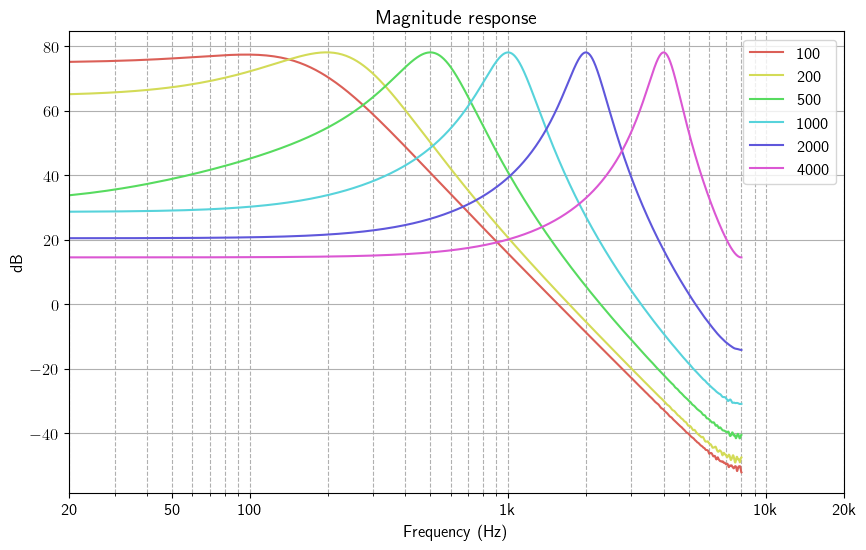

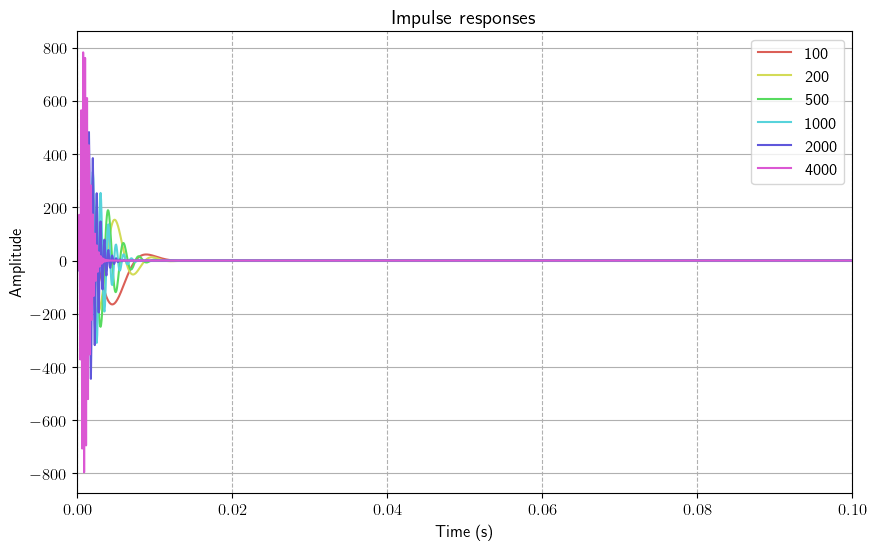

Impaired filterbank


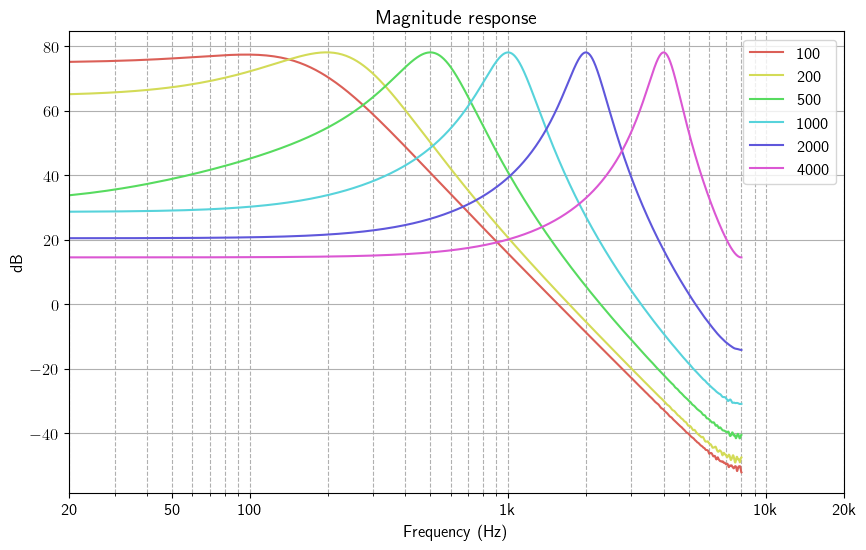

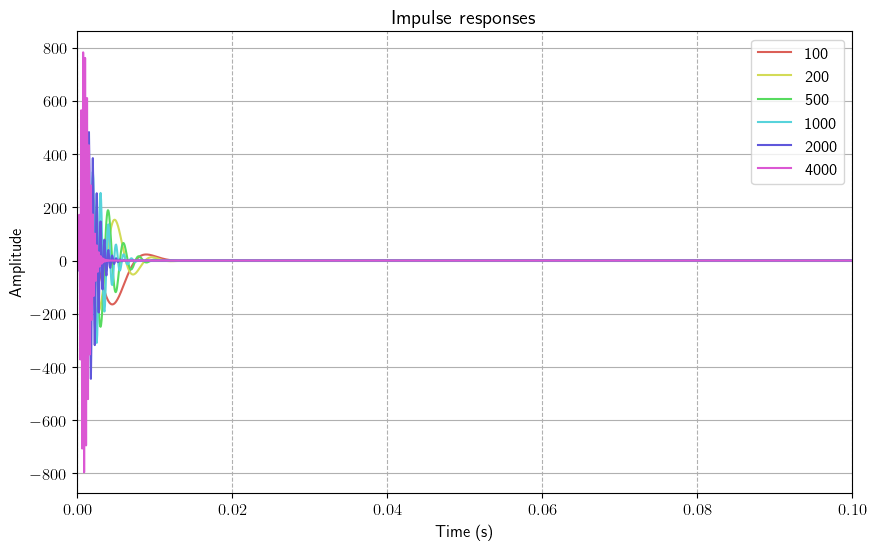

In [4]:
# initiate a normal hearing gammatone filterbank
filterbank_NH = GammaToneFilterbank(
    duration=0.25,
    center_frequencies=center_frequencies,
    fs_hz=samplerate,
    impairment_factor=0,
)

# initiate a impaired gammatone filterbank
filterbank_HI = GammaToneFilterbank(
    duration=0.25,
    center_frequencies=center_frequencies,
    fs_hz=samplerate,
    impairment_factor=100,
)


print("Normal hearing filterbank")
plot_gammabank(filterbank_HI,center_frequencies=center_frequencies)
print("Impaired filterbank")
plot_gammabank(filterbank_HI,center_frequencies=center_frequencies)

In [5]:
import torch.optim as optim

# Dummy training data
# Random input data and target labels
n_batch = 1
n_samples = 16_000
n_channels = 1

model = MyModel_v1(
    num_taps=100,
    samplerate=samplerate, 
    center_frequencies=center_frequencies,
    impairment_factor=1000,
)

print(model)

MyModel_v1(
  (normal_model): NormalModel(
    (gamma_bank): GammaToneFilterbank(
      (filters): ModuleList(
        (0-5): 6 x GammaToneFilter()
      )
    )
  )
  (impaired_model): ImpairedModel(
    (gamma_bank): GammaToneFilterbank(
      (filters): ModuleList(
        (0-5): 6 x GammaToneFilter()
      )
    )
    (gain): FIRFilter1D()
  )
)


input audio


normal hearing  output


impaired output


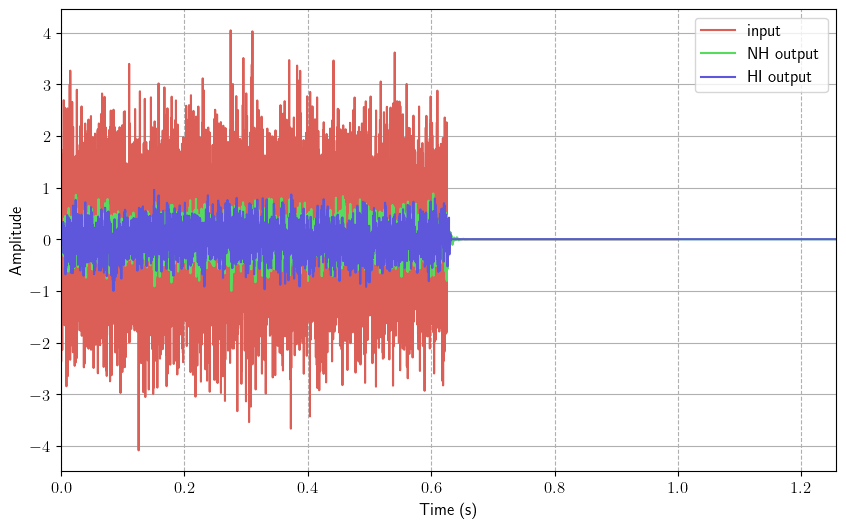

In [11]:
x_noise = torch.randn(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
x_noise[:,:,10000:] = 0.0  # Input of length 10, all zeros
x_d = torch.zeros(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
x_d[:, :, 0:1000] = 1.0  # Impulse

# choose which signal to excite with
x = x_noise

# out_NH, out_HI = model(x_noise)
out_NH, out_HI = model(x)

print("input audio")
audio_play(batch_2_np(x),samplerate)
print("normal hearing  output")
audio_play(batch_2_np(out_NH),samplerate)
print("impaired output")
audio_play(batch_2_np(out_HI),samplerate)


signals = [
    batch_2_np(x),
    batch_2_np(out_NH),
    batch_2_np(out_HI),
]

plot.timeseries(signals,samplerate=samplerate,
                labels=['input','NH output', 'HI output'])

input audio


normal hearing  output


impaired output


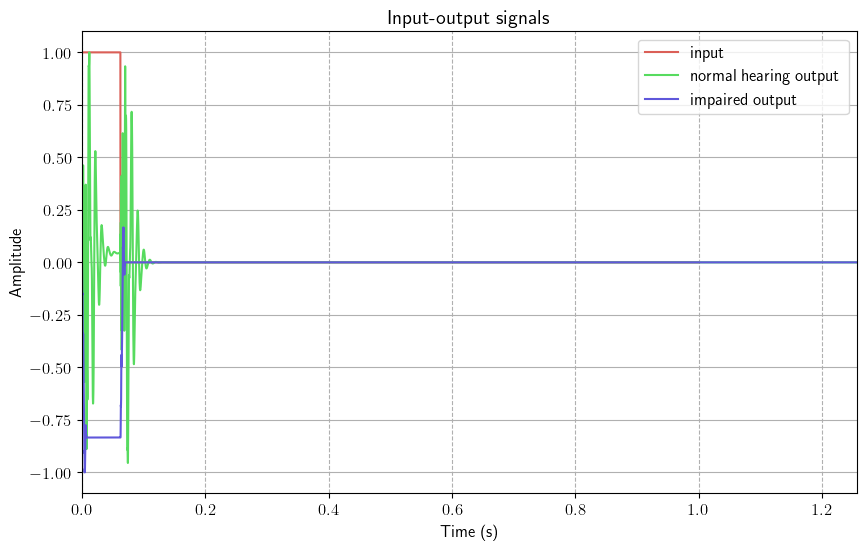

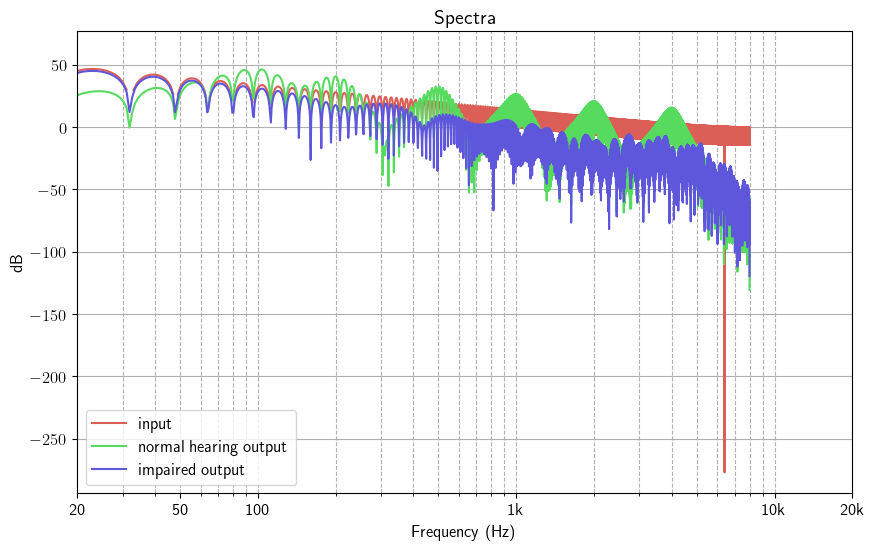

In [10]:

# choose which signal to excite with
x = x_d

# out_NH, out_HI = model(x_noise)
out_NH, out_HI = model(x)

print("input audio")
audio_play(batch_2_np(x),samplerate)
print("normal hearing  output")
audio_play(batch_2_np(out_NH),samplerate)
print("impaired output")
audio_play(batch_2_np(out_HI),samplerate)

freq_axes = []
spec_axes = []
time_signals = []

for filter in [batch_2_np(x), batch_2_np(out_NH), batch_2_np(out_HI)]:
    h, f = utils.get_spectrum(filter, samplerate=samplerate)
    freq_axes.append(f)
    spec_axes.append(h)
    time_signals.append(filter)

# Plot IR in time-domain and magnitude repsonse
plot.timeseries(
    time_signals, samplerate=samplerate, title="Input-output signals",
    labels=['input','normal hearing output', 'impaired output']
)
plot.magspec(freq_axes=freq_axes, spec_axes=spec_axes, title="Spectra",
                 labels=['input','normal hearing output', 'impaired output']
)

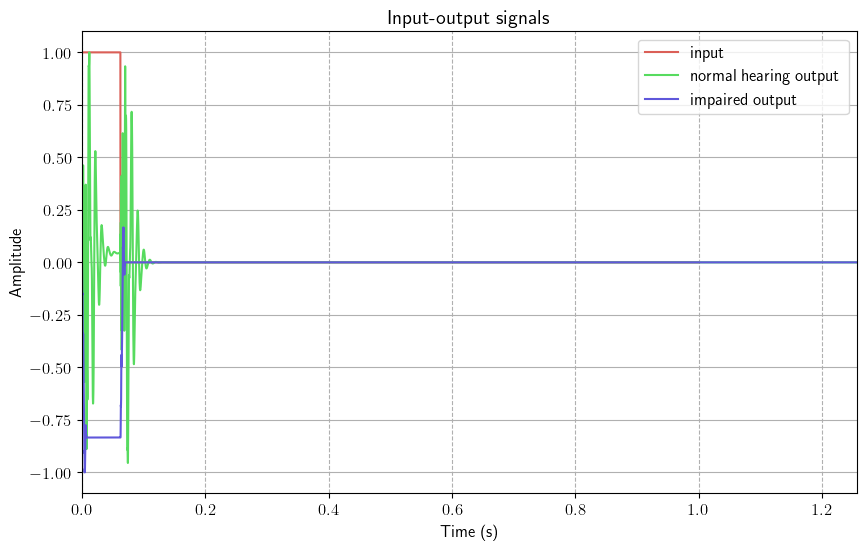

c:\Users\STNj\OneDrive - Demant\Documents\DTU\DDSP\tools\utils.py:138: RuntimeWarning: divide by zero encountered in log10
  return 20 * log10(abs(complex_spectrum))


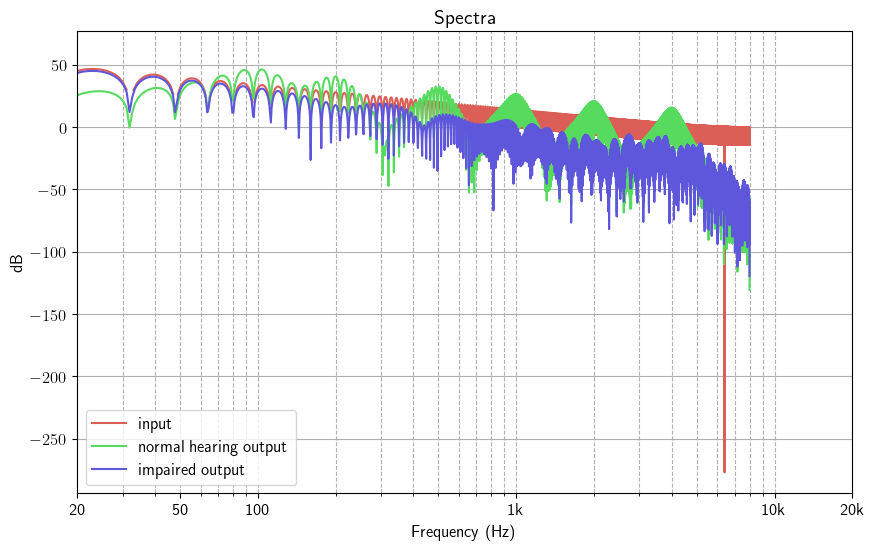